<center><h1> Agent-Based Model of Panic</h1> </center>

## Imports

In [2]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy import stats
import statistics
import numpy as np
from itertools import combinations
import seaborn as sns
# random.seed(1234)

## Model Class

In [9]:
class Model():

    def __init__(self, num_of_agents=10, num_iterations=10, mode ='heterogeneous', verbose=False):
        self.num_of_agents = num_of_agents
        self.num_iterations = num_iterations
        self.mode = mode
        self.verbose = verbose
        
        #parameter values
        self.beta = 0.1
        self.alpha = 0.1
        self.gamma = 0.1
        self.value = 1.5 
        self.time = 0 #model time
        
        
        #creating lists
        self.num_infected_per_iteration_homogeneous = list()
        self.num_infected_per_iteration_heterogeneous = list()
        self.infected_agents = list() 
        self.num_of_infected = 0

        
        #create the agents
        self.agents = []
        for i in range(num_of_agents):
            # adding each new created agent to a list
            if self.mode == 'homogeneous' or 'heterogeneous':
                self.agents.append(Agent(self))
                
        #setting beta parameters and number of subgroups 
        self.param_vals = (0.05, 0.6) #setting beta values for all subgroups
        self.n_groups = len(self.param_vals) #number of subgroups
        
        for i, agent in enumerate(self.agents):
            group_number = i % self.n_groups  #dividing agents into equal subgroups
            agent.beta = self.param_vals[group_number]  #assigning each agent their specific beta according to agent groups 
            agent.group_number = group_number #making sure agents know their group numbers
        
        self.update_agent_groups() 
        
        
    def update_agent_groups(self):
        '''
        This function updates all subgroups,
        by updating each subgroup with each agent
        '''
        self.agent_groups = [list() for _ in range(self.n_groups)] #creating a list that contains all lists of subgroups
        
        for i, agent in enumerate(self.agents):
            group_number = i % self.n_groups
            self.agent_groups[group_number].append(agent) #updates the list of agents 
        
    
    def get_num_infected_homogeneous(self):
        '''
        This function retrieves the number of agents that are infected,
        specifically in the homogeneous mode
        '''
        return len(([ a for a in self.agents if a.state==1 ])) #returns the length of agents in an infected state

    def get_num_infected_heterogeneous(self, group_number):
        '''
        This function retrieves the number of agents that are infected,
        by subgroup number in the heterogeneous mode
        '''
        return len(([ a for a in self.agent_groups[group_number] if a.state==1 ])) #returns the length of infected agents in each subgroup.
    
    def get_subgroup_states(self, t):
        '''
        This function creates a dictionary of the agents state, 
        number of infected, subgroup and associated beta values
        '''
        results = list()
        
        for i, pv in enumerate(self.param_vals):
            sub_group_num_infected = self.get_num_infected_heterogeneous(i)
            d = {'t': t, 'group number': i,
                 'I': sub_group_num_infected,
                 'beta': pv}
            results.append(d)
        return results
    
        #if the model hasn't finished running yet
        self.model_finished = False 
    
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents:
                agent.step()
            
            if self.verbose:
                for i, agent in enumerate(self.agents):
                    print('Agent {0}/{1}:'.format(i, self.num_of_agents))    
                    if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                        print('my likelihood:{}, my state:{}'.format( agent.likelihood, agent.state))
            
            self.update_agent_groups()

            self.num_infected_per_iteration_homogeneous.append(self.get_num_infected_homogeneous())
            
            subgroup_num_infected = self.get_subgroup_states(t)
            
            self.num_infected_per_iteration_heterogeneous.extend(subgroup_num_infected)
                                                          
            if self.verbose:
                if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                    print('step: {},  total infected:{}'.format(t, self.get_num_infected_homogeneous()))
    
            #step time
            self.time += 1
            
        infected_agents = list()
        
        for agent in self.agents:
            if agent.state == 1:
                infected_agents.append(agent)
        self.num_of_infected = len(infected_agents)
        self.infected_agents.append(self.num_of_infected)
            
        #once each iteration is done, model is finished
        self.model_finished = True
        self.num_infected_per_iteration_heterogeneous = pd.DataFrame(self.num_infected_per_iteration_heterogeneous)

    def graph_num_infected(self):
        '''
        Uses matplotlib to create a graph
        '''
        if not self.model_finished:
            print("Can't print the number of infected until the model has finished")
            return
        
        # Create a figure and an axis (if you want more than one plot in the same
        # figure you can adjust the subplots function)
        
        fig, ax = plt.subplots(num=None, figsize=(5, 3), dpi=128, facecolor='w', edgecolor='k')
        
        # Do a scatter plot
        if self.mode == 'homogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration_homogeneous],
                    c="#5FC6CA", label=" Total infected") 
            
        if self.mode == 'heterogeneous':
            sns.lineplot(data=self.num_infected_per_iteration_heterogeneous, x='t', y='I', hue='beta', ax=ax)
        
        ax.set_title("Number of Infected per Iteration")
        ax.set_ylim(0,len(self.agents)) # limit the y axis
        ax.set_xlabel("Iteration (time)")
        ax.set_ylabel("Number of Panicked (Infected) Agents")
        ax.legend(loc='upper left')
        
        plt.savefig("Number of Infected Agents Through Time - 1000 ", bbox_inches="tight")

## Agent Class

In [12]:
class Agent():
    
    def __init__(self, model, alpha = 0.1, beta = 0.1, gamma= 0.3):
        
        #intialising parameters
        self.state = 0
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta 
        self.likelihood = 0

        #pointer to the model class
        self.model = model


    def step(self):
        if self.state == 0:
            if self.model.mode == 'heterogeneous':
                self.heterogeneous_model()
                self.other_agents
            elif self.model.mode == 'homogeneous':
                self.homogeneous_model()
                self.other_agents
        else:
            self.recover()
          
        
    def homogeneous_model(self):
        '''
        For the homogeneous mode we get a reference agent,
        which agents will use to decide how to compute their likelihood according to
        the reference agents' state
        '''
        Agent_i = random.choice(self.model.agents)
        
        if Agent_i.state == 1:
            self.likelihood = self.alpha + self.beta
        else:
            self.likelihood = self.alpha
        
        r = random.random()
        if r < self.likelihood: 
            self.state = 1

    def heterogeneous_model(self):
        '''
        For the heterogeneous mode, agents choose a reference agent from their group,
        to then decide how to compute their likelihood according to the reference agents' state
        '''
        subgroup = self.model.agent_groups[self.group_number]
#             print(self.group_number, len(subgroup))
        sample_agent = random.choice(subgroup)

        if sample_agent.state == 1:
            self.likelihood = self.alpha + self.beta
        elif sample_agent.state == 0:
            self.likelihood = self.alpha


        r = random.random()
        if r < self.likelihood:
            self.state = 1

    def other_agents(self):
        '''
        In this function, if the number of infected is greater than half of the agent population,
        all agents instantaneously become infected
        '''
        if model.num_of_infected > model.num_of_agents/model.value:
            self.state = 1
    
    def recover(self):
        '''
        This function recovers agents from infection randomly
        '''
        if self.state == 1:
            r1 = random.random()
            if r1 < self.gamma:
                self.state = 0

## Running model

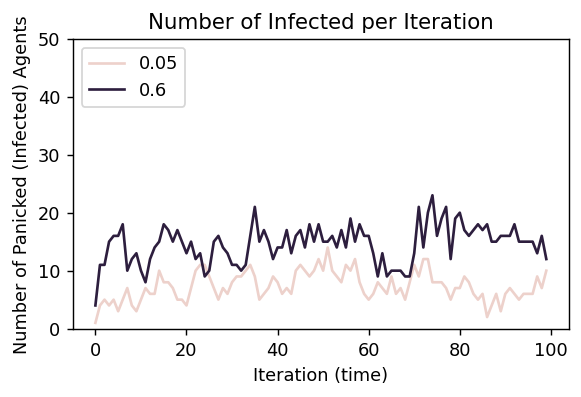

In [13]:
model = Model(num_of_agents=50, num_iterations=100, mode = 'heterogeneous')
model.run()
model.graph_num_infected()